# Predicting air temperatures from LST

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import zipfile
import os
import rasterio
import requests
import tempfile
import shutil
from rasterio.warp import transform
from pyproj import Transformer
from zipfile import ZipFile
from datetime import datetime, timedelta
from shapely.geometry import Point
import hvplot.pandas
from shapely.geometry import box
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from math import sqrt

## Data Preparation

Filtering low cloud cover scenes across time (<= 10%)

In [2]:
# List of zip file paths for metadata
zip_file_paths_metadata = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8\L8_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9\L9_Metadata.zip"
] # Excludes Landsat 5, 7 because number and type of bands are not uniform across Landsat 5-7

def filtering_cc(zip_file_paths_metadata, cloud_cover):
    # List to store dates and times of low cloud cover images
    low_cloud_cover_dates = []

    # Process each zip file
    for zip_file_path in zip_file_paths_metadata:
        with zipfile.ZipFile(zip_file_path, 'r') as z:
            # List all contained files that end with .csv
            csv_files = [f for f in z.namelist() if f.endswith('.csv')]
            
            # Process each CSV file
            for csv_file in csv_files:
                with z.open(csv_file) as f:
                    # Read the file into a pandas DataFrame
                    df = pd.read_csv(f)
                    
                    # Filter data where CLOUD_COVER <= cloud_cover
                    if df['CLOUD_COVER'].iloc[0] <= cloud_cover:
                        # Extract the date and time from the file name
                        date_time = os.path.basename(csv_file).split('_')[2] + '_' + os.path.basename(csv_file).split('_')[3].split('.')[0]
                        low_cloud_cover_dates.append(date_time)

    # Print or return the dates for further processing
    print("Dates with cloud cover <= " + str(cloud_cover) + "%:")
    for date_time in low_cloud_cover_dates:
        print(date_time)

    return low_cloud_cover_dates

In [3]:
cc30_dates = filtering_cc(zip_file_paths_metadata, 30)

Dates with cloud cover <= 30%:
20230927_031644
20230522_031555
20240202_031642
20231029_031651
20231013_031648
20230725_031624
20240218_031642
20230623_031606
20210703_031632
20220417_031628
20210124_031646
20220401_031622
20200310_031632
20200529_031605
20200122_031646
20200716_031630
20190730_031640
20190527_031619
20190204_031624
20180727_031552
20180812_031602
20180217_031625
20180508_031543
20180422_031552
20180524_031532
20171215_031648
20171028_031656
20170724_031632
20170318_031619
20190103_031630
20170419_031603
20160705_031630
20160331_031617
20160416_031612
20150921_031636
20151226_031646
20160228_031631
20151210_031644
20170708_031625
20150703_031603
20160502_031615
20141207_031646
20150414_031601
20140513_031612
20150225_031625
20140411_031642
20140529_031612
20140222_031724
20210617_031628
20140326_031655
20170926_031650
20140902_031644
20160923_031652
20230615_031557
20231005_031644
20231106_031647
20240617_031549
20240313_031647
20230412_031631
20220324_031636
20230919_

Merging air temperature data at weather stations with weather station metadata (i.e. longitude/latitude coordinates)

In [172]:
# Filtering date and time specific air temperature data
dates_to_filter_utc = [datetime.strptime(date, "%Y%m%d_%H%M%S") for date in cc30_dates if int(date[:4]) >= 2017]
dates_to_filter_gmt8 = [date + timedelta(hours=8) for date in dates_to_filter_utc]

def fetch_station_data(dates):
    base_path_temp = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature"
    base_path_wind = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\WindSpeed"
    station_details = pd.DataFrame()

    # Process each date for both temperature and windspeed
    for date in dates:
        year = date.strftime('%Y')
        file_path_temp = f"{base_path_temp}\AirTemperature_{year}.csv"
        file_path_wind = f"{base_path_wind}\WindSpeed_{year}.csv"

        try:
            # Read and process temperature data
            df_temp = pd.read_csv(file_path_temp)
            df_wind = pd.read_csv(file_path_wind)
            
            # Format the 'timestamp' for filtering
            filter_str = date.strftime('%Y-%m-%dT%H:%M')
            
            # Filter data
            filtered_df_temp = df_temp[df_temp['timestamp'].astype(str).apply(lambda x: x.startswith(filter_str))].copy()
            filtered_df_wind = df_wind[df_wind['timestamp'].astype(str).apply(lambda x: x.startswith(filter_str))].copy()
            
            # Rename columns in wind data for clarity
            if not filtered_df_wind.empty:
                filtered_df_wind.rename(columns={'temperature': 'windspeed'}, inplace=True)
            
            # Join on 'station_id' and 'timestamp' if both dataframes have entries
            if not filtered_df_temp.empty and not filtered_df_wind.empty:
                combined_df = pd.merge(filtered_df_temp, filtered_df_wind, on=['station_id', 'timestamp'], how='inner')
                station_details = pd.concat([station_details, combined_df])
                print(combined_df)
                
        except FileNotFoundError as e:
            print(f"No file found for the year {year} with error: {str(e)}")

    return station_details

# Get the filtered data
filtered_station_data = fetch_station_data(dates_to_filter_gmt8)
print(filtered_station_data)

# filtered_station_data.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\AirTemperature_cc30.csv", index=False)
# filtered_station_data.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\AirTemperature_WindSpeed_cc30.csv", index=False)

                    timestamp station_id  temperature  windspeed
0   2023-09-27T11:16:00+08:00       S109         31.4    5.30000
1   2023-09-27T11:16:00+08:00       S117         31.2    8.00000
2   2023-09-27T11:16:00+08:00        S50         30.4    6.90000
3   2023-09-27T11:16:00+08:00       S107         30.6   11.10000
4   2023-09-27T11:16:00+08:00        S43         32.7    3.20000
5   2023-09-27T11:16:00+08:00       S121         31.8    8.10001
6   2023-09-27T11:16:00+08:00       S111         32.1    8.00000
7   2023-09-27T11:16:00+08:00        S60         31.3    6.10000
8   2023-09-27T11:16:00+08:00       S115         31.1    2.90000
9   2023-09-27T11:16:00+08:00        S24         31.4   12.00000
10  2023-09-27T11:16:00+08:00       S116         30.8    4.00000
11  2023-09-27T11:16:00+08:00       S104         32.2    4.60000
                    timestamp station_id  temperature  windspeed
0   2023-05-22T11:15:00+08:00       S109         31.4        4.2
1   2023-05-22T11:15:00+0

In [7]:
# Define the base URL for the API
base_url = "https://api.data.gov.sg/v1/environment/air-temperature"

def fetch_station_metadata(dates):
    """Fetches metadata for weather stations on specific dates and ensures unique station entries."""
    station_dict = {}  # Using a dictionary to avoid duplicate station entries

    for date_obj in dates:
        # Format date object to the required string format for API request
        date_str = date_obj.strftime('%Y-%m-%d')
        response = requests.get(f"{base_url}?date={date_str}")
        if response.status_code == 200:
            data = response.json()
            stations = data['metadata']['stations']
            for station in stations:
                station_id = station['id']
                if station_id not in station_dict:
                    # Only add new station details if not already in dictionary
                    station_dict[station_id] = {
                        'station_id': station['device_id'],
                        'name': station['name'],
                        'longitude': station['location']['longitude'],
                        'latitude': station['location']['latitude']
                    }
            print("Station metadata fetched for " + date_str)
        else:
            print(f"Failed to fetch data for {date_str}")

    # Convert dictionary to DataFrame for easy handling and viewing
    return pd.DataFrame.from_dict(station_dict, orient='index')

# Example usage with the corrected dates_to_filter list
station_metadata = fetch_station_metadata(dates_to_filter_gmt8)
print(station_metadata)

# station_metadata.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\StationMetadata_cc30.csv", index=False)

Station metadata fetched for 2023-09-27
Station metadata fetched for 2023-05-22
Station metadata fetched for 2024-02-02
Station metadata fetched for 2023-10-29
Station metadata fetched for 2023-10-13
Station metadata fetched for 2023-07-25
Station metadata fetched for 2024-02-18
Station metadata fetched for 2023-06-23
Station metadata fetched for 2021-07-03
Station metadata fetched for 2022-04-17
Station metadata fetched for 2021-01-24
Station metadata fetched for 2022-04-01
Station metadata fetched for 2020-03-10
Station metadata fetched for 2020-05-29
Station metadata fetched for 2020-01-22
Station metadata fetched for 2020-07-16
Station metadata fetched for 2019-07-30
Station metadata fetched for 2019-05-27
Station metadata fetched for 2019-02-04
Station metadata fetched for 2018-07-27
Station metadata fetched for 2018-08-12
Station metadata fetched for 2018-02-17
Station metadata fetched for 2018-05-08
Station metadata fetched for 2018-04-22
Station metadata fetched for 2018-05-24


In [175]:
filtered_station_data = pd.read_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\AirTemperature_WindSpeed_cc30.csv")
station_metadata = pd.read_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\StationMetadata_cc30.csv")

def preparing_air_temps_cc30_gdf(filtered_station_data, station_metadata):
    air_temps_cc30 = filtered_station_data.merge(station_metadata, on='station_id', how='left')

    air_temps_cc30_gdf = gpd.GeoDataFrame(air_temps_cc30, geometry=gpd.points_from_xy(air_temps_cc30.longitude, air_temps_cc30.latitude))

    air_temps_cc30_gdf['timestamp_datetime'] = pd.to_datetime(air_temps_cc30_gdf['timestamp'])
    air_temps_cc30_gdf['time'] = air_temps_cc30_gdf['timestamp_datetime'].dt.strftime('%Y-%m-%d')

    if air_temps_cc30_gdf.crs is None:
        air_temps_cc30_gdf = air_temps_cc30_gdf.set_crs('EPSG:4326')

    air_temps_cc30_gdf = air_temps_cc30_gdf.to_crs('EPSG:3857')

    return air_temps_cc30_gdf

air_temps_wind_speed_cc30_gdf = preparing_air_temps_cc30_gdf(filtered_station_data, station_metadata)

air_temps_wind_speed_cc30_gdf.head()

,timestamp,station_id,temperature,windspeed,name,longitude,latitude,geometry,timestamp_datetime,time
0,2023-09-27T11:16:00+08:00,S109,31.4,5.3,Ang Mo Kio Avenue 5,103.8492,1.3764,POINT (11560440.063 153234.886),2023-09-27 11:16:00+08:00,2023-09-27
1,2023-09-27T11:16:00+08:00,S117,31.2,8.0,Banyan Road,103.6790,1.2560,POINT (11541493.486 139828.480),2023-09-27 11:16:00+08:00,2023-09-27
2,2023-09-27T11:16:00+08:00,S50,30.4,6.9,Clementi Road,103.7768,1.3337,POINT (11552380.532 148480.214),2023-09-27 11:16:00+08:00,2023-09-27
3,2023-09-27T11:16:00+08:00,S107,30.6,11.1,East Coast Parkway,103.9625,1.3135,POINT (11573052.562 146230.960),2023-09-27 11:16:00+08:00,2023-09-27
4,2023-09-27T11:16:00+08:00,S43,32.7,3.2,Kim Chuan Road,103.8878,1.3399,POINT (11564736.996 149170.583),2023-09-27 11:16:00+08:00,2023-09-27


Filtering pixels at specific weather station locations for all dates with cloud cover <= 10%

In [39]:
singapore_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\singapore-boundary.geojson"
singapore_boundary = gpd.read_file(singapore_geojson_path)
singapore_boundary = singapore_boundary.set_crs('EPSG:4326')
singapore_boundary = singapore_boundary.to_crs('EPSG:3857')

singapore_boundary

,geometry
0,"MULTIPOLYGON (((11533294.805 138488.988, 11533..."


In [37]:
# List of zip file paths for Landsat data
zip_file_paths = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9"
]

In [178]:
# Landsat images -> tabular format -> EPSG:3857 coordinates system -> Singapore boundaries -> filter pixels at specific weather stations

def process_landsat_data(date_str, zip_file_paths, singapore_boundary, weather_readings_gdf):
    year = date_str[:4]
    data_list = []
    date_obj = datetime.strptime(date_str, "%Y%m%d_%H%M%S")
    formatted_date_str = date_obj.strftime('%Y-%m-%d')

    for path in zip_file_paths:
        zip_filename = f"{year}.zip"
        zip_filepath = os.path.join(path, zip_filename)
        
        if os.path.exists(zip_filepath):
            with ZipFile(zip_filepath, 'r') as z:
                tif_files = [f for f in z.namelist() if f.endswith('.tif') and date_str in f]
                print(tif_files)
                for tif_file in tif_files:
                    temp_dir = tempfile.mkdtemp()
                    z.extract(tif_file, temp_dir)
                    tif_path = os.path.join(temp_dir, tif_file)
                    
                    with rasterio.open(tif_path) as src:
                        array = src.read()  # Read all bands
                        transform = src.transform
                        src_crs = src.crs  # Source CRS
                        dest_crs = 'EPSG:3857'  # Target CRS

                        transformer = Transformer.from_crs(src_crs, dest_crs, always_xy=True)

                        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
                        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

                        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())
                        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
                        
                        for i, band in enumerate(src.read(masked=True)):
                            df[src.descriptions[i] if src.descriptions[i] else f"band_{i+1}"] = band.flatten()

                        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
                        gdf.set_crs(dest_crs, inplace=True)
                        gdf = gpd.sjoin(gdf, singapore_boundary, how="inner", predicate='within')

                        # print("Number of pixels in Singapore's boundaries: " + str(len(gdf)))
                        # print(gdf)

                        # Create 30m x 30m boxes around each point
                        gdf['geometry'] = gdf['geometry'].apply(
                            lambda p: box(p.x - 15, p.y - 15, p.x + 15, p.y + 15)
                        )
                        print("30m by 30m pixels created for " + formatted_date_str + ". Conducting spatial join...")
                        gdf = gdf.drop('index_right', axis=1)

                        joined_gdf = gpd.sjoin(weather_readings_gdf[weather_readings_gdf['time'] == formatted_date_str], gdf, how="left", predicate='intersects')

                        # print("Length of joined GeoDataFrame: " + str(len(joined_gdf)))
                        # print(joined_gdf)

                        data_list.append(joined_gdf)

                    shutil.rmtree(temp_dir)

                    return joined_gdf

weather_readings_gdf = gpd.GeoDataFrame()

for date in dates_to_filter_utc:
    date_str = date.strftime('%Y%m%d_%H%M%S')
    gdf = process_landsat_data(date_str, zip_file_paths, singapore_boundary, air_temps_wind_speed_cc30_gdf)
    if gdf is not None:
        print(gdf)
        weather_readings_gdf = pd.concat([weather_readings_gdf, gdf], ignore_index=True)
        print("Finished processing Landsat scene on " + date_str)
        # print(gdf.head())
    else:
        print(f"No GeoDataFrame returned for {date_str}")

['2023/L8_UTC_20230927_031644.tif']
30m by 30m pixels created for 2023-09-27. Conducting spatial join...
                    timestamp station_id  temperature  windspeed  \
0   2023-09-27T11:16:00+08:00       S109         31.4    5.30000   
1   2023-09-27T11:16:00+08:00       S117         31.2    8.00000   
2   2023-09-27T11:16:00+08:00        S50         30.4    6.90000   
3   2023-09-27T11:16:00+08:00       S107         30.6   11.10000   
4   2023-09-27T11:16:00+08:00        S43         32.7    3.20000   
5   2023-09-27T11:16:00+08:00       S121         31.8    8.10001   
6   2023-09-27T11:16:00+08:00       S111         32.1    8.00000   
7   2023-09-27T11:16:00+08:00        S60         31.3    6.10000   
8   2023-09-27T11:16:00+08:00       S115         31.1    2.90000   
9   2023-09-27T11:16:00+08:00        S24         31.4   12.00000   
10  2023-09-27T11:16:00+08:00       S116         30.8    4.00000   
11  2023-09-27T11:16:00+08:00       S104         32.2    4.60000   

          

## Training Machine Learning Model

Improve the model by:
- Using high-quality pixels (i.e. filtering based on aerosol levels and cloud cover)
- Conducting feature selection (choosing top K features)
- Adding wind speeds as a feature

In [76]:
air_temps_pixels_gdf.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\air_temps_pixels_cc30_l8_9.csv", index=False)

In [179]:
weather_readings_gdf.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\weather_reading_pixels_cc30_l8_9.csv", index=False)

In [201]:
weather_readings_gdf = pd.read_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\air_temps_pixels_cc30_l8_9.csv")

weather_readings_gdf.rename(columns={'temperature': 'AirTemp'}, inplace=True)
weather_readings_gdf.rename(columns={'windspeed': 'WindSpeed'}, inplace=True)

In [81]:
def preprocessing_model_data(cc30_pixels_air_temps_gdf):
    # Scaling bands and creating bands for model training and prediction (eg. LST, NDVI, NDBI)

    # Calculate LST for available columns
    cc30_pixels_air_temps_gdf['ST_B10_Celsius'] = cc30_pixels_air_temps_gdf['ST_B10'] * 0.00341802 + 149 - 273.15

    # Scale and offset values for SR_B4 (Near Infrared) and SR_B5 (Shortwave Infrared 1)
    scale = 2.75e-05
    offset = -0.2

    # Apply scale and offset to the bands
    cc30_pixels_air_temps_gdf['SR_B1_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B1'] * scale) + offset
    cc30_pixels_air_temps_gdf['SR_B2_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B2'] * scale) + offset
    cc30_pixels_air_temps_gdf['SR_B3_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B3'] * scale) + offset
    cc30_pixels_air_temps_gdf['SR_B4_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B4'] * scale) + offset
    cc30_pixels_air_temps_gdf['SR_B5_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B5'] * scale) + offset
    cc30_pixels_air_temps_gdf['SR_B6_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B6'] * scale) + offset
    cc30_pixels_air_temps_gdf['SR_B7_Scaled'] = (cc30_pixels_air_temps_gdf['SR_B7'] * scale) + offset

    cc30_pixels_air_temps_gdf['ST_URAD_Scaled'] = (cc30_pixels_air_temps_gdf['ST_URAD'] * 0.001)
    cc30_pixels_air_temps_gdf['ST_DRAD_Scaled'] = (cc30_pixels_air_temps_gdf['ST_DRAD'] * 0.001)
    cc30_pixels_air_temps_gdf['ST_ATRAN_Scaled'] = (cc30_pixels_air_temps_gdf['ST_ATRAN'] * 0.0001)
    cc30_pixels_air_temps_gdf['ST_CDIST_Scaled'] = (cc30_pixels_air_temps_gdf['ST_CDIST'] * 0.01)
    cc30_pixels_air_temps_gdf['ST_EMIS_Scaled'] = (cc30_pixels_air_temps_gdf['ST_EMIS'] * 0.0001)
    cc30_pixels_air_temps_gdf['ST_EMSD_Scaled'] = (cc30_pixels_air_temps_gdf['ST_EMSD'] * 0.0001)

    # NDVI
    cc30_pixels_air_temps_gdf['NDVI'] = (cc30_pixels_air_temps_gdf['SR_B5_Scaled'] - cc30_pixels_air_temps_gdf['SR_B4_Scaled']) / (cc30_pixels_air_temps_gdf['SR_B5_Scaled'] + cc30_pixels_air_temps_gdf['SR_B4_Scaled'])

    # NBDI
    cc30_pixels_air_temps_gdf['NDBI'] = (cc30_pixels_air_temps_gdf['SR_B6_Scaled'] - cc30_pixels_air_temps_gdf['SR_B5_Scaled']) / (cc30_pixels_air_temps_gdf['SR_B6_Scaled'] + cc30_pixels_air_temps_gdf['SR_B5_Scaled'])

    # Surface Albedo
    cc30_pixels_air_temps_gdf['Albedo'] = (0.356*cc30_pixels_air_temps_gdf['SR_B2_Scaled'] + 0.130*cc30_pixels_air_temps_gdf['SR_B4_Scaled'] 
                                               + 0.373*cc30_pixels_air_temps_gdf['SR_B5_Scaled'] + 0.085*cc30_pixels_air_temps_gdf['SR_B6_Scaled'] 
                                               + 0.072*cc30_pixels_air_temps_gdf['SR_B7_Scaled'] - 0.0018)
    
    print(cc30_pixels_air_temps_gdf.head())

    return cc30_pixels_air_temps_gdf

In [202]:
weather_readings_gdf = preprocessing_model_data(weather_readings_gdf)

                   timestamp station_id  AirTemp                 name  \
0  2023-09-27T11:16:00+08:00       S109     31.4  Ang Mo Kio Avenue 5   
1  2023-09-27T11:16:00+08:00       S117     31.2          Banyan Road   
2  2023-09-27T11:16:00+08:00        S50     30.4        Clementi Road   
3  2023-09-27T11:16:00+08:00       S107     30.6   East Coast Parkway   
4  2023-09-27T11:16:00+08:00        S43     32.7       Kim Chuan Road   

   longitude  latitude                                       geometry  \
0   103.8492    1.3764   POINT (11560440.063288825 153234.8862409321)   
1   103.6790    1.2560   POINT (11541493.48595581 139828.47986307956)   
2   103.7768    1.3337  POINT (11552380.532155393 148480.21422894482)   
3   103.9625    1.3135  POINT (11573052.561595704 146230.96035656676)   
4   103.8878    1.3399  POINT (11564736.995633446 149170.58296884727)   

          timestamp_datetime        time  index_right  ...  SR_B7_Scaled  \
0  2023-09-27 11:16:00+08:00  2023-09-27     6

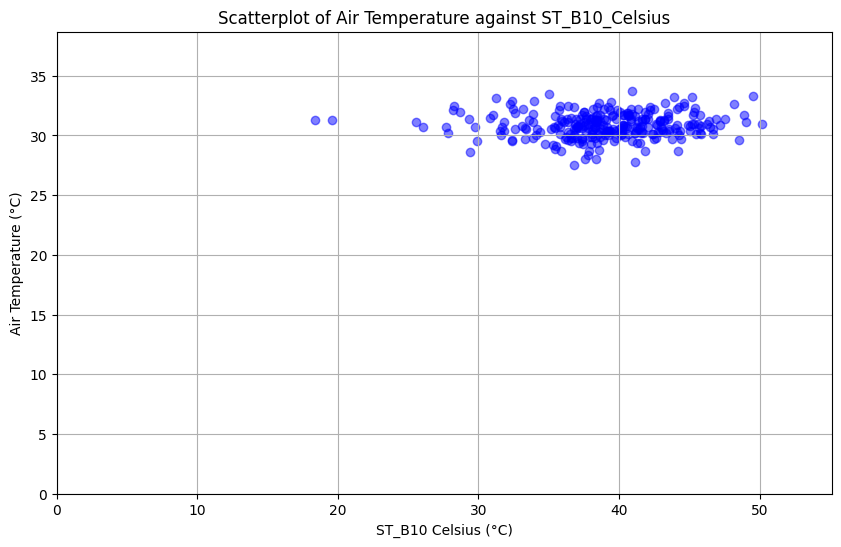

In [203]:
# Define the filtering values
# qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

def scatter_plot_air_temps_against_LST(air_temps_pixels_gdf):
    qa_pixel_filter_2 = [5504, 5506, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56660, 56916]
    sr_qa_aerosol_filter_2 = [192, 194, 196]

    # Filter out unwanted 'QA_PIXEL' values
    filtered_air_temps_pixels_gdf = air_temps_pixels_gdf[~air_temps_pixels_gdf['QA_PIXEL'].isin(qa_pixel_filter_2)]

    # Further filter out unwanted 'SR_QA_AEROSOL' values
    filtered_air_temps_pixels_gdf = filtered_air_temps_pixels_gdf[~filtered_air_temps_pixels_gdf['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_2)]

    # Ensure the data does not contain NaN values for accurate plotting
    df_plot = filtered_air_temps_pixels_gdf.dropna(subset=['AirTemp', 'ST_B10_Celsius'])

    plt.figure(figsize=(10, 6))
    plt.scatter(df_plot['ST_B10_Celsius'], df_plot['AirTemp'], color='blue', alpha=0.5)
    plt.title('Scatterplot of Air Temperature against ST_B10_Celsius')
    plt.xlabel('ST_B10 Celsius (°C)')
    plt.ylabel('Air Temperature (°C)')
    plt.grid(True)

    # Setting the limits to start from 0
    plt.xlim([0, max(df_plot['ST_B10_Celsius'])+5])  # Add a small buffer for better visualization
    plt.ylim([0, max(df_plot['AirTemp'])+5])

    plt.show()

    return filtered_air_temps_pixels_gdf

filtered_air_temps_pixels_gdf = scatter_plot_air_temps_against_LST(weather_readings_gdf)

## Support Vector Regression

Fitting 5 folds for each of 20 candidates, totalling 100 fits


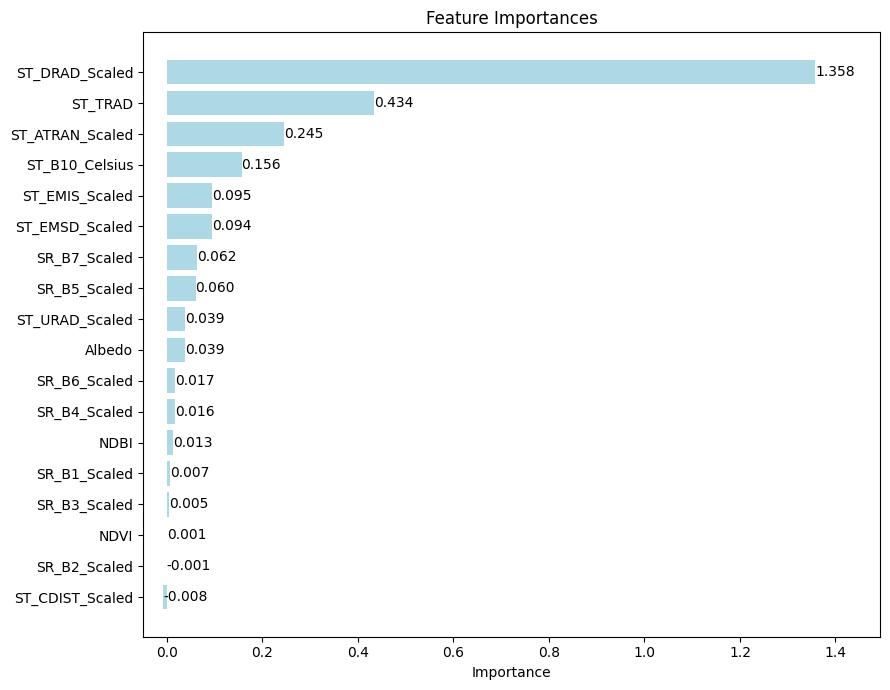

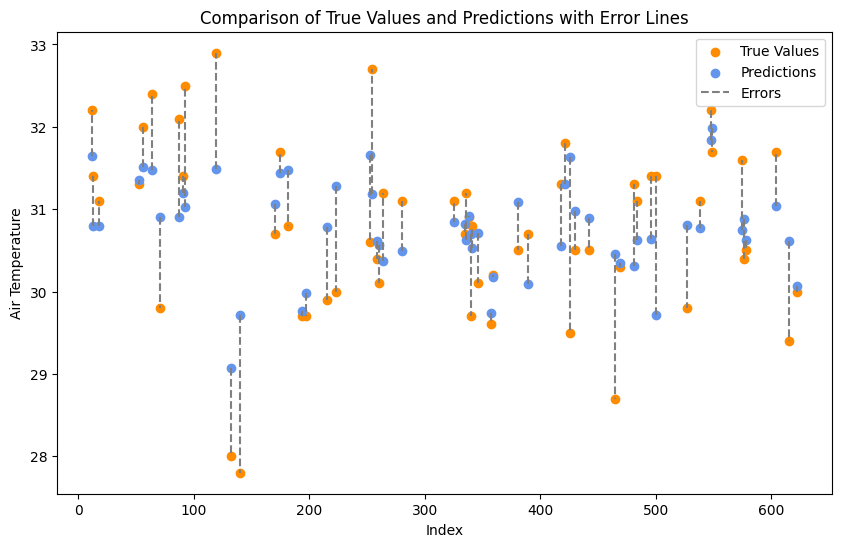


Selected features: Index(['ST_B10_Celsius', 'ST_ATRAN_Scaled', 'ST_TRAD', 'ST_DRAD_Scaled'], dtype='object')

Best model parameters: {'svr__epsilon': 0.6214705882352941, 'svr__C': 10.0}

Train R²: 0.41118598602255907 Test R²: 0.3471696021612414

Train MSE: 0.7931851852635649 Test MSE: 0.8483129713080055


In [225]:
def svr(filtered_air_temps_pixels_gdf):
    # Define bands to drop
    bands_to_drop = ['AirTemp', 'geometry', 'name', 'time', 'timestamp', 'station_id', 'longitude', 'latitude', 'Longitude', 'Latitude',
                     'timestamp_datetime', 'index_right', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 
                     'SR_B7', 'ST_B10', 'QA_PIXEL', 'QA_RADSAT', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 
                     'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_URAD', 'SR_QA_AEROSOL']

    # Prepare data
    X = filtered_air_temps_pixels_gdf.drop(bands_to_drop, axis=1)
    y = filtered_air_temps_pixels_gdf['AirTemp']

    # Handle NaNs in the dataset
    X = X.dropna()
    y = y.loc[X.index]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model pipeline
    pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'svr__C': np.logspace(-1, 1, 15),
        'svr__epsilon': np.linspace(0.01, 1, 35)
    }

    # Setup for RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        verbose=3,
        scoring='neg_mean_squared_error',  # Specify to use negative MSE as the scoring function
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV
    search.fit(X_train, y_train)

    # Find the best model
    best_model = search.best_estimator_

    # Calculate feature importances using Python's permutation_importance function
    results = permutation_importance(best_model, X_test, y_test, n_repeats=100, random_state=42, n_jobs=-1)
    feature_importance = results.importances_mean

    # Plotting the feature importances with scores
    fig, ax = plt.subplots(figsize=(9, 7))
    sorted_idx = np.argsort(feature_importance)
    bars = ax.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color='lightblue')
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importances')

    # Add text annotations to the bars
    for bar, value in zip(bars, feature_importance[sorted_idx]):
        text = f"{value:.3f}"
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, text, va='center')

    # Adjust margins or set limits to avoid cutting off text
    ax.set_xlim(-0.05, max(feature_importance) * 1.1)  # Adjust x-axis limit for padding

    plt.tight_layout()  # Adjust subplots to give some more room
    plt.show()

    # Select features based on importance, limit to sqrt(n_features)
    n_features = int(np.sqrt(X_train.shape[1]))
    important_indices = sorted_idx[-n_features:]
    selected_features = X_train.columns[important_indices]

    # Refit model with selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    best_model.fit(X_train_selected, y_train)

    # Predict using the refined model
    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    # Plot the predicted values against the true values
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test.index, y_test, color='darkorange', label='True Values')
    plt.scatter(X_test.index, y_test_pred, color='cornflowerblue', label='Predictions')
    plt.vlines(X_test.index, y_test_pred, y_test, colors='gray', linestyles='dashed', label='Errors')
    plt.title('Comparison of True Values and Predictions with Error Lines')
    plt.xlabel('Index')
    plt.ylabel('Air Temperature')
    plt.legend()
    plt.show()

    # Calculate and print evaluation metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print("\nSelected features:", selected_features)
    print("\nBest model parameters:", search.best_params_)
    print("\nTrain R²:", train_r2, "Test R²:", test_r2)
    print("\nTrain MSE:", sqrt(train_mse), "Test MSE:", sqrt(test_mse))

    return best_model

svr_best_model = svr(filtered_air_temps_pixels_gdf)

In [129]:
# Landsat images -> tabular format -> EPSG:3857 coordinates system -> Singapore boundaries
# Preparing Landsat scene for air temperature prediction using best SVR model

def process_landsat_data_test(date_str, zip_file_paths, singapore_boundary):
    year = date_str[:4]
    data_list = []
    date_obj = datetime.strptime(date_str, "%Y%m%d_%H%M%S")
    formatted_date_str = date_obj.strftime('%Y-%m-%d')

    for path in zip_file_paths:
        zip_filename = f"{year}.zip"
        zip_filepath = os.path.join(path, zip_filename)
        
        if os.path.exists(zip_filepath):
            with ZipFile(zip_filepath, 'r') as z:
                tif_files = [f for f in z.namelist() if f.endswith('.tif') and date_str in f]
                print(tif_files)
                for tif_file in tif_files:
                    temp_dir = tempfile.mkdtemp()
                    z.extract(tif_file, temp_dir)
                    tif_path = os.path.join(temp_dir, tif_file)
                    
                    with rasterio.open(tif_path) as src:
                        array = src.read()  # Read all bands
                        transform = src.transform
                        src_crs = src.crs  # Source CRS
                        dest_crs = 'EPSG:3857'  # Target CRS

                        transformer = Transformer.from_crs(src_crs, dest_crs, always_xy=True)

                        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
                        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

                        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())
                        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
                        
                        for i, band in enumerate(src.read(masked=True)):
                            df[src.descriptions[i] if src.descriptions[i] else f"band_{i+1}"] = band.flatten()

                        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
                        gdf.set_crs(dest_crs, inplace=True)
                        gdf = gpd.sjoin(gdf, singapore_boundary, how="inner", predicate='within')

                        # print("Number of pixels in Singapore's boundaries: " + str(len(gdf)))
                        # print(gdf)

                        # Create 30m x 30m boxes around each point
                        gdf['geometry'] = gdf['geometry'].apply(
                            lambda p: box(p.x - 15, p.y - 15, p.x + 15, p.y + 15)
                        )
                        print("30m by 30m pixels created for " + formatted_date_str + ". Conducting spatial join...")
                        gdf = gdf.drop('index_right', axis=1)

                        data_list.append(gdf)

                    shutil.rmtree(temp_dir)

                    return gdf

predicted_air_temps_pixels_gdf = gpd.GeoDataFrame()

date_str = "20230522_031555"
gdf = process_landsat_data_test(date_str, zip_file_paths, singapore_boundary)

if gdf is not None:
    print(gdf)
    predicted_air_temps_pixels_gdf = pd.concat([predicted_air_temps_pixels_gdf, gdf], ignore_index=True)
    print("Finished processing Landsat scene on " + date_str)
    # print(gdf.head())
else:
    print(f"No GeoDataFrame returned for {date_str}")

['2023/L8_UTC_20230522_031555.tif']
30m by 30m pixels created for 2023-05-22. Conducting spatial join...
            Longitude       Latitude    SR_B1    SR_B2    SR_B3    SR_B4  \
807      1.155578e+07  163682.833193  35987.0  36658.0  36109.0  36901.0   
808      1.155581e+07  163682.849332  35209.0  35651.0  35747.0  36343.0   
809      1.155584e+07  163682.865467  34670.0  35227.0  34988.0  35741.0   
810      1.155587e+07  163682.881599  32616.0  33341.0  32907.0  33767.0   
811      1.155590e+07  163682.897728  30459.0  31267.0  31016.0  31906.0   
...               ...            ...      ...      ...      ...      ...   
2042730  1.154832e+07  129052.597973   8021.0   8566.0   9253.0   8736.0   
2042731  1.154835e+07  129052.611412   7936.0   8414.0   9951.0   9566.0   
2042732  1.154838e+07  129052.624848   8691.0   9566.0  11132.0  11127.0   
2044513  1.154835e+07  129022.398431   8366.0   8877.0  10285.0   9967.0   
2044514  1.154838e+07  129022.411864   8237.0   8851.0  101

In [130]:
predicted_air_temps_pixels_gdf = preprocessing_model_data(predicted_air_temps_pixels_gdf)

      Longitude       Latitude    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
0  1.155578e+07  163682.833193  35987.0  36658.0  36109.0  36901.0  37931.0   
1  1.155581e+07  163682.849332  35209.0  35651.0  35747.0  36343.0  37123.0   
2  1.155584e+07  163682.865467  34670.0  35227.0  34988.0  35741.0  36842.0   
3  1.155587e+07  163682.881599  32616.0  33341.0  32907.0  33767.0  35287.0   
4  1.155590e+07  163682.897728  30459.0  31267.0  31016.0  31906.0  33892.0   

     SR_B6    SR_B7  SR_QA_AEROSOL  ...  SR_B7_Scaled  ST_URAD_Scaled  \
0  34552.0  28400.0          224.0  ...      0.581000           4.703   
1  35571.0  29526.0          192.0  ...      0.611965           4.703   
2  35635.0  29902.0          224.0  ...      0.622305           4.703   
3  33776.0  28163.0          224.0  ...      0.574483           4.703   
4  32306.0  26379.0          192.0  ...      0.525423           4.703   

   ST_DRAD_Scaled  ST_ATRAN_Scaled  ST_CDIST_Scaled  ST_EMIS_Scaled  \
0           2.0

In [239]:
bands_to_keep = ['ST_B10_Celsius', 'ST_ATRAN_Scaled', 'ST_TRAD', 'ST_DRAD_Scaled'] # Copy from chosen feature selection method

def predict_landsat_scene(predicted_air_temps_pixels_gdf, air_temps_cc30_gdf):
    # Copy Longitude and Latitude into a new DataFrame for later use
    geo_info = predicted_air_temps_pixels_gdf[['Longitude', 'Latitude']].copy()

    # Keep only the specified bands in the DataFrame
    predicted_air_temps_pixels_gdf = predicted_air_temps_pixels_gdf[bands_to_keep]

    # Drop rows with missing values in the specified bands
    predicted_air_temps_pixels_gdf = predicted_air_temps_pixels_gdf.dropna()

    # Predict using the best model for the specified date
    y_date_pred = best_model.predict(predicted_air_temps_pixels_gdf)

    # Add predictions back to the DataFrame
    predicted_air_temps_pixels_gdf['AirTemps_Prediction'] = y_date_pred

    # Reintegrate Longitude and Latitude into the DataFrame
    predicted_air_temps_pixels_gdf = predicted_air_temps_pixels_gdf.join(geo_info)

    # Create a GeoDataFrame with proper geographic data
    air_temps_plot_gdf = gpd.GeoDataFrame(predicted_air_temps_pixels_gdf, geometry=gpd.points_from_xy(predicted_air_temps_pixels_gdf['Longitude'], predicted_air_temps_pixels_gdf['Latitude']))

    # Set the coordinate reference system (CRS) to WGS84
    air_temps_plot_gdf = air_temps_plot_gdf.set_crs(epsg=4326, inplace=True)

    # Print the predictions for the specific date
    print(f"Predictions for 2023-05-22:\n{y_date_pred}")

    if air_temps_plot_gdf.crs is None:
        air_temps_plot_gdf = air_temps_plot_gdf.set_crs('EPSG:3857')

    min_temp = air_temps_plot_gdf['AirTemps_Prediction'].min()
    max_temp = air_temps_plot_gdf['AirTemps_Prediction'].max()

    air_temp_plot = air_temps_plot_gdf.hvplot(
        # geo=True,
        c='AirTemps_Prediction',
        cmap='reds',
        clim=(min_temp, max_temp),
        hover_cols=['AirTemps_Prediction'],
        tiles='OSM',
        colorbar=True,
        frame_width=600,
        frame_height=450,
        size=10
    )

    weather_stations_date_gdf = air_temps_cc30_gdf[air_temps_cc30_gdf['time'] == '2023-05-22']

    weather_stations_plot = weather_stations_date_gdf.hvplot(
        # geo=True,
        c='green',
        # cmap='blues',
        # clim=(min_temp, max_temp),
        hover_cols=['temperature'],
        colorbar=True,
        frame_width=600,
        frame_height=450,
        size=200,
        marker='^'
    )

    air_temp_plot * weather_stations_plot

    return air_temp_plot * weather_stations_plot

predict_landsat_scene(predicted_air_temps_pixels_gdf, air_temps_cc30_gdf)

Predictions for 2023-05-22:
[30.00574054 30.03775163 30.06746365 ... 30.5445765  30.54759513
 30.55465997]


## Gradient Boosting

Fitting 10 folds for each of 20 candidates, totalling 200 fits


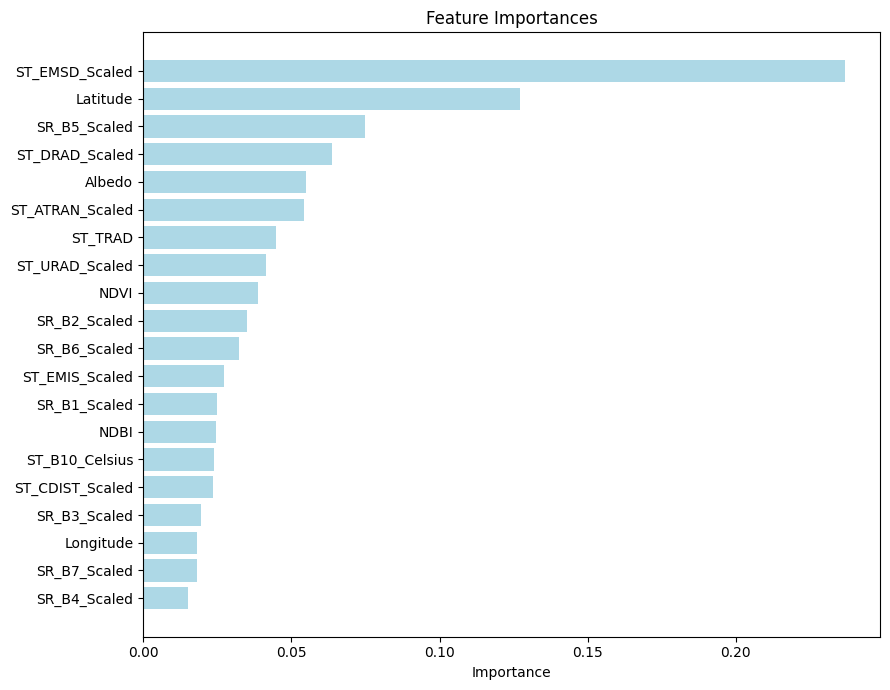

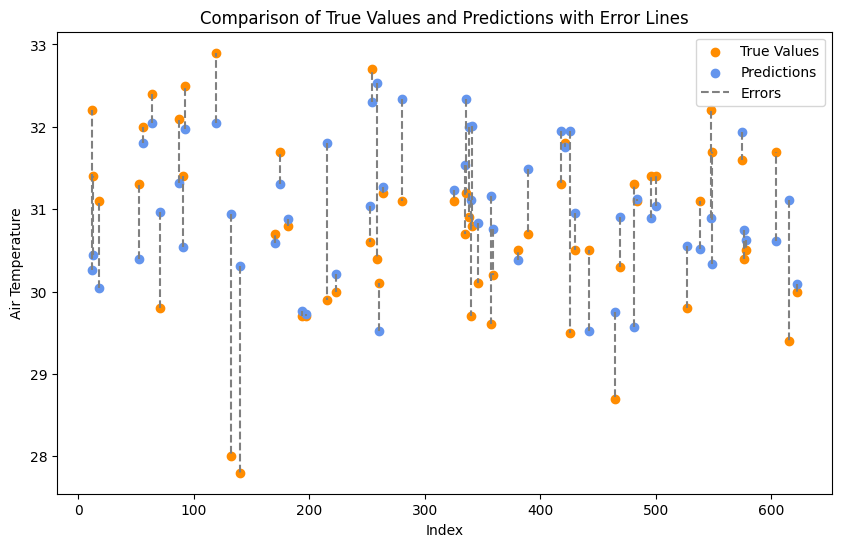


Selected features: Index(['ST_DRAD_Scaled', 'SR_B5_Scaled', 'Latitude', 'ST_EMSD_Scaled'], dtype='object')

Best model parameters: {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}

Train R²: 0.9633147007101959 Test R²: -0.06400446858767461

Train RMSE: 0.19798466743990434 Test RMSE: 1.082997987295542


In [234]:
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
# from sklearn.inspection import permutation_importance
# from sklearn.metrics import mean_squared_error, r2_score
# from math import sqrt
# import matplotlib.pyplot as plt
# import numpy as np

# def xgb_regressor(filtered_air_temps_pixels_gdf):
#     bands_to_drop = ['AirTemp', 'geometry', 'name', 'time', 'timestamp', 'station_id', 'longitude', 'latitude', 
#                      'timestamp_datetime', 'index_right', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 
#                      'SR_B7', 'ST_B10', 'QA_PIXEL', 'QA_RADSAT', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 
#                      'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_URAD', 'SR_QA_AEROSOL']

#     X = filtered_air_temps_pixels_gdf.drop(bands_to_drop, axis=1)
#     y = filtered_air_temps_pixels_gdf['AirTemp']
#     X = X.dropna()
#     y = y.loc[X.index]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     model = XGBRegressor(objective='reg:squarederror', random_state=42)

#     param_grid = {
#         'n_estimators': np.arange(100, 301, 100),
#         'max_depth': [3, 5, 7],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'reg_alpha': [0.01, 0.1],
#         'reg_lambda': [0.01, 0.1]
#     }

#     search = RandomizedSearchCV(
#         estimator=model,
#         param_distributions=param_grid,
#         n_iter=20,
#         cv=10,  # Increased number of folds
#         verbose=3,
#         scoring='neg_mean_squared_error',
#         random_state=42,
#         n_jobs=-1
#     )

#     search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

#     best_model = search.best_estimator_
#     feature_importance = best_model.feature_importances_
#     fig, ax = plt.subplots(figsize=(9, 7))
#     sorted_idx = np.argsort(feature_importance)
#     bars = ax.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color='lightblue')
#     ax.set_xlabel('Importance')
#     ax.set_title('Feature Importances')
#     plt.tight_layout()
#     plt.show()

#     n_features = int(np.sqrt(X_train.shape[1]))
#     important_indices = sorted_idx[-n_features:]
#     selected_features = X_train.columns[important_indices]

#     X_train_selected = X_train[selected_features]
#     X_test_selected = X_test[selected_features]
#     best_model.fit(X_train_selected, y_train)

#     y_train_pred = best_model.predict(X_train_selected)
#     y_test_pred = best_model.predict(X_test_selected)

#     plt.figure(figsize=(10, 6))
#     plt.scatter(X_test.index, y_test, color='darkorange', label='True Values')
#     plt.scatter(X_test.index, y_test_pred, color='cornflowerblue', label='Predictions')
#     plt.vlines(X_test.index, y_test_pred, y_test, colors='gray', linestyles='dashed', label='Errors')
#     plt.title('Comparison of True Values and Predictions with Error Lines')
#     plt.xlabel('Index')
#     plt.ylabel('Air Temperature')
#     plt.legend()
#     plt.show()

#     train_r2 = r2_score(y_train, y_train_pred)
#     test_r2 = r2_score(y_test, y_test_pred)
#     train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
#     test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))

#     print("\nSelected features:", selected_features)
#     print("\nBest model parameters:", search.best_params_)
#     print("\nTrain R²:", train_r2, "Test R²:", test_r2)
#     print("\nTrain RMSE:", train_rmse, "Test RMSE:", test_rmse)

#     return best_model

# # Running the model
# xgb_best_model = xgb_regressor(filtered_air_temps_pixels_gdf)

## Random Forest

In [146]:
# Parameters of Random Forest Regressor Model: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/ 
# Reference literature/study: https://www.frontiersin.org/journals/environmental-science/articles/10.3389/fenvs.2021.791336/full 
# Hyperparameter tuning: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 

def random_forest(air_temps_pixels_gdf): # n_iter=10 and cv=5; test MSE=0.8127979236991412 
    # Define dropped bands and features
    bands_to_drop = ['AirTemp', 'geometry', 'name', 'time', 'timestamp', 'station_id', 'longitude', 'latitude', 'timestamp_datetime', 'index_right',
                     'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10',
                     'QA_PIXEL', 'QA_RADSAT', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_URAD', 'SR_QA_AEROSOL']
    X = air_temps_pixels_gdf.drop(bands_to_drop, axis=1)
    y = air_temps_pixels_gdf['AirTemp']

    # Handling NaNs in the dataset
    X = X.dropna()
    y = y.loc[X.index]

    if y.empty:
        print("Empty dataset after preprocessing. Check your data or preprocessing steps.")
        return None

    # Splitting the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Defining the parameter grid for RandomizedSearchCV
    # param_grid = {
    #     'n_estimators': [20, 25, 30],
    #     'max_depth': [5, 8, 10],
    #     'min_samples_split': [5, 8, 10],
    #     'min_samples_leaf': [5, 8, 10],
    #     'max_features': ['log2'],
    #     'max_leaf_nodes': [8, 10, 12],
    #     'max_samples': [0.4, 0.5, 0.6]
    # }

    param_grid = {
        'n_estimators': [75, 100, 125],
        'max_depth': [8, 10],
        'min_samples_split': [20, 25, 30],
        'min_samples_leaf': [10, 12, 15],
        'max_features': ['log2'],
        'max_leaf_nodes': [15, 20],
        'max_samples': [0.5, 0.6, 0.7]
    }

    # Setup for RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   cv=5,
                                   verbose=3,  # Increased verbosity to see the progress more clearly
                                   random_state=42,
                                   n_jobs=-1)
    
    # Conducting k-fold cross validation ensures that the hyperparameter tuning does not overfit to this specific Landsat scene

    # Fitting RandomizedSearchCV
    rf_random.fit(X_train, y_train)

    # Finding the best model and predicting
    best_model = rf_random.best_estimator_

    # Output feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_,
                                       index = X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print("\nFeature Importances:\n", feature_importances)

    # Predicting and evaluating
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Plot the predicted values against the true values
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test.index, y_test, color='darkorange', label='True Values')
    plt.scatter(X_test.index, y_test_pred, color='cornflowerblue', label='Predictions')
    plt.vlines(X_test.index, y_test_pred, y_test, colors='gray', linestyles='dashed', label='Errors')

    plt.title('Comparison of True Values and Predictions with Error Lines')
    plt.xlabel('Index')
    plt.ylabel('Air Temperature')
    plt.legend()
    plt.show()

    # Calculate scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Output results
    print("\nBest model parameters:", rf_random.best_params_)
    print("\nTrain R²:", train_r2, "Test R²:", test_r2)
    print("\nTrain MSE:", train_mse, "Test MSE:", test_mse)

    return best_model

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Feature Importances:
                  importance
ST_TRAD            0.108325
ST_B10_Celsius     0.084998
ST_DRAD_Scaled     0.071817
ST_EMSD_Scaled     0.070653
Longitude          0.061708
NDVI               0.056894
ST_ATRAN_Scaled    0.054988
Latitude           0.053203
ST_EMIS_Scaled     0.051794
ST_URAD_Scaled     0.049155
SR_B5_Scaled       0.042848
SR_B2_Scaled       0.038201
SR_B4_Scaled       0.037408
SR_B3_Scaled       0.036352
SR_B6_Scaled       0.035123
SR_B7_Scaled       0.034635
Albedo             0.032478
NDBI               0.031828
SR_B1_Scaled       0.024262
ST_CDIST_Scaled    0.023330


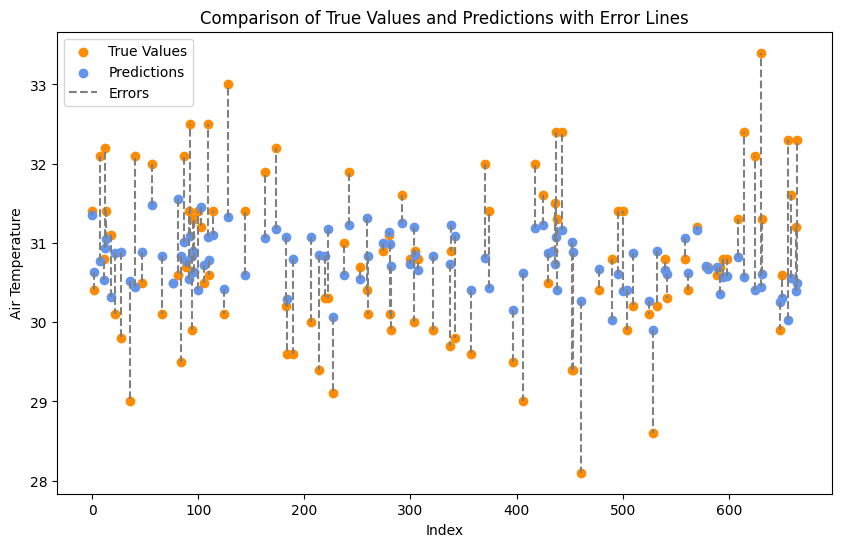


Best model parameters: {'n_estimators': 125, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_samples': 0.7, 'max_leaf_nodes': 20, 'max_features': 'log2', 'max_depth': 8}

Train R²: 0.39956692645150194 Test R²: 0.057632879077675336

Train MSE: 0.7307692738882401 Test MSE: 0.9091225030453423


In [46]:
# Ensure your data is loaded correctly before calling the function
rf_model = random_forest(air_temps_pixels_gdf)